<a href="https://colab.research.google.com/github/felipekbatista/microscopic_images/blob/master/code_versions/v1/image_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [ ]:
import numpy as np
import cv2
import pandas as pd
from matplotlib import pyplot as plt
from skimage import io, img_as_float
import seaborn as sns
from skimage.filters import roberts, sobel, scharr, prewitt
from scipy import ndimage as nd
import seaborn as sns

# Paths 

In [ ]:
path_das_imagens = '/content/drive/My Drive/Colab Notebooks/arrombado/modelos/m_01.jpg'
mask_path = '/content/drive/My Drive/Colab Notebooks/arrombado/modelos/m_01_template.tiff'

# Feature engineering

## Filter bank

---
Functions to automate the creation of features for use in the model


- Use 'train_model' for prepare the image for training the model
- Use 'implement_model' for prepare the image for being loaded in the model

In [ ]:

def train_model(path, mask_path):
    'process the image for train the model'
    'retorns df with features and the label column'
    img = _importar_imagem(path)
    df_1 = _process_img(img)
    df_1 = _get_label(mask_path, df_1)
    print('train_model concluded')
    return df_1

def implement_model(path):
    'process the image for use in the trained model'
    ' returns: df, image dimensions and the img in grayscale'
    img = _importar_imagem(path)
    df_1 = _process_img(img)
    a,b = _get_shape(img)
    print('implement_model concluded')
    return df_1, a,b, img

def _importar_imagem(path):
    'enter the img path '
    'returns the img in grayscale'
    img = cv2.imread(path)
    #img = io.imread(path)
    #img = np.array(img, dtype=np.uint8)
    #dtype = np.uint8
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def _get_shape(img):
    'returns shape of img'
    largura = img.shape[0]
    altura = img.shape[1]
    return largura, altura

def _process_img(img):
    'uses the img for feature extraction'
    df_1 = pd.DataFrame()
    df_1['original_img'] = img.reshape(-1)
    # reescrever as funçoes para os filtros
    df_1 = _get_gabor(df_1, img)
    df_1 = _get_canny(img, df_1)
    df_1 = _get_prewitt(img, df_1)
    df_1 = _get_roberts(img, df_1)
    df_1 = _get_scharr(img, df_1)
    df_1 = _get_sobel(img, df_1)
    for sigma in [0.5,1,2,3,4,5]:
        df_1 = _get_gaussian(img, df_1, sigma)
    print('function executed')
    return df_1

def _get_gabor(df_1, img):

    # GABOR filter
    pi = np.pi
    num = 1
    kernels = []

    theta_bank = [0, 0.7853981633974483] 
    sigma = 1
    lamda_bank = [0.7853981633974483, 1.5707963267948966,2.356194490192345 ]
    gamma_bank = [0.05, 0.5, 1]

    for theta in theta_bank:
        for lamda in lamda_bank:
            for gamma in gamma_bank:
                gabor_label = 'gabor'+str(num)
                ksize = 5
                kernel = cv2.getGaborKernel((ksize,ksize), sigma,theta, lamda, gamma,0, ktype = cv2.CV_32F)
                kernels.append(kernel) # add o kernel criado numa lista
                filtered_img = cv2.filter2D(img, cv2.CV_8UC3, kernel) #filtra a imagem com o kernel_gabor
                df_1[gabor_label] = filtered_img.reshape(-1) # add a imagem filtrada no df, como um feature
                #print(gabor_label, 'theta',theta, 'sigma', sigma, 'lamda', lamda, 'gamma', gamma)
                num += 1

    return df_1


'''
    for theta in range(2): #humber of thetas
        theta = theta / 8 * np.pi
        for sigma in (0.5, 1, 1.5, 2, 2.5, 3): # uses sigma 1 and 3
            for lamda in np.arange(0, pi, pi/8):
                for gamma in (0.05 , 0.5, 1, 1.5 ):
                    #generate the gabor kernel
                    gabor_label = 'gabor'+str(num)
                    ksize = 5
                    kernel = cv2.getGaborKernel((ksize,ksize), sigma,theta, lamda, gamma,0, ktype = cv2.CV_32F)
                    
                    kernels.append(kernel) # add o kernel criado numa lista
                    
                    filtered_img = cv2.filter2D(img_1, cv2.CV_8UC3, kernel) #filtra a imagem com o kernel_gabor
                    df_1[gabor_label] = filtered_img.reshape(-1) # add a imagem filtrada no df, como um feature
                    print(gabor_label, 'theta',theta, 'sigma', sigma, 'lamda', lamda, 'gamma', gamma)
                    num += 1
'''
# gabor params filter data
    
    
    
        
def _get_canny(img, df_1):
    #edges - canny
    canny = cv2.Canny(img, 100,200)
    df_1['canny'] = canny.reshape(-1)
    return df_1

def _get_roberts(img, df_1):
    roberts_ = roberts(img)
    roberts_ = roberts_.reshape(-1)
    df_1['roberts'] = roberts_
    return df_1

def _get_sobel(img, df_1):
    sobel_ = sobel(img)
    sobel_ = sobel_.reshape(-1)
    df_1['sobel_'] = sobel_
    return df_1

def _get_scharr(img, df_1):
    scharr_ = scharr(img)
    scharr_ = scharr_.reshape(-1)
    df_1['scharr'] = scharr_
    return df_1

def _get_prewitt(img, df_1):
    prewitt_ = prewitt(img)
    prewitt_ = prewitt_.reshape(-1)
    df_1['prewitt'] = prewitt_
    return df_1

def _get_gaussian(img, df_1, sigma_):
    gaussian_label = 'gauss_sigma_' + str(sigma_)
    gaussian = nd.gaussian_filter(img, sigma_)
    gaussian = gaussian.reshape(-1)
    df_1[gaussian_label] = gaussian
    return df_1

def _get_label(mask_path, df_1):
    'insert labeled img for the model and returns the labels to the df'
    'the labeled img is returned as a binary img'
    labeled_img = _importar_imagem(mask_path)
    segm_1 = (labeled_img > 0)
    all_segm = np.zeros( (labeled_img.shape[0],labeled_img.shape[1]), dtype=float)
    all_segm = segm_1 
    all_segm = all_segm.astype(float)
    df_1['labels'] = all_segm.reshape(-1)
    return df_1


In [ ]:
#df1 = treina_modelo() ('/content/drive/My Drive/Colab Notebooks/arrombado/modelos/m_01.jpg', '/content/drive/My Drive/Colab Notebooks/arrombado/modelos/m_01_template.tiff')
#path_das_imagens = /content/drive/My Drive/Colab Notebooks/arrombado/modelos/m_01.jpg'
#mask_path = '/content/drive/My Drive/Colab Notebooks/arrombado/modelos/m_01_template.tiff'

---

# ML

## Dados

In [ ]:
print(path_das_imagens)
print(mask_path)

/content/drive/My Drive/Colab Notebooks/arrombado/modelos/m_01.jpg
/content/drive/My Drive/Colab Notebooks/arrombado/modelos/m_01_template.tiff


In [ ]:
df = pd.DataFrame()
for i in range(1,5):
        df1 = train_model('/content/drive/My Drive/Colab Notebooks/arrombado/modelos/m_0{}.jpg'.format(i),'/content/drive/My Drive/Colab Notebooks/arrombado/modelos/m_0{}_template.tiff'.format(i))
        df = pd.concat([df, df1] )
        df.reset_index(drop = True, inplace = True)
        print('run: ', i, 'df.shape = ', df.shape)
    


function executed
df.shape =  (3137536, 31)
function executed
df.shape =  (6275072, 31)
function executed
df.shape =  (9412608, 31)
function executed
df.shape =  (12550144, 31)
tamanho df (12550144, 31)


## Data split

In [ ]:
x = df1.drop(labels = ['labels'], axis = 1)
y = df1['labels']
x.head()

This datasplit was used for the first run, to train the model

In [ ]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y , test_size = 0.4, random_state = 42)

## Model Train

RFC with 10 estimators

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 10, random_state = 42)
model.fit(x, y)
ypredict_1 = model.predict(x)

## model evaluation

In [ ]:
from sklearn import metrics
print('dados usados: xtrain \n')
print('accuracy: ', metrics.accuracy_score(y, ypredict_1).round(2))

print('\n\ndados usados: xtest zn')    

#ypredict_2 = model.predict(xtest)
#print('accuracy: ', metrics.accuracy_score(ytest, ypredict_2).round())



dados usados: xtrain 

accuracy:  1.0


dados usados: xtest zn


## Feature importances

In [ ]:
importances = list(model.feature_importances_.round(4))
importances

features = pd.DataFrame( data = importances, index= x.columns)
features.sort_values(by = 0 ,ascending = False, inplace=True)
features.shape
features

,0
gauss_sigma_0.5,0.1165
gauss_sigma_3,0.1119
gauss_sigma_1,0.0826
gauss_sigma_2,0.0757
original_img,0.0743
gabor1,0.0707
gabor12,0.0692
gabor6,0.0503
prewitt,0.0336
scharr,0.0313


Text(0.5, 0, 'Score (fraction)')

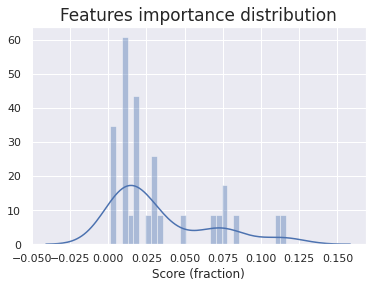

In [ ]:
sns.set(style = 'darkgrid')
ax = sns.distplot(features, kde = True, bins = 30)
ax.set_title('Features importance distribution', fontsize = 17)
ax.set_xlabel('Score (fraction)')

The KDE plot shows some 3 zones of interest: a low score, medium score and high score zones. 




## Teste com outra imagem

function executed


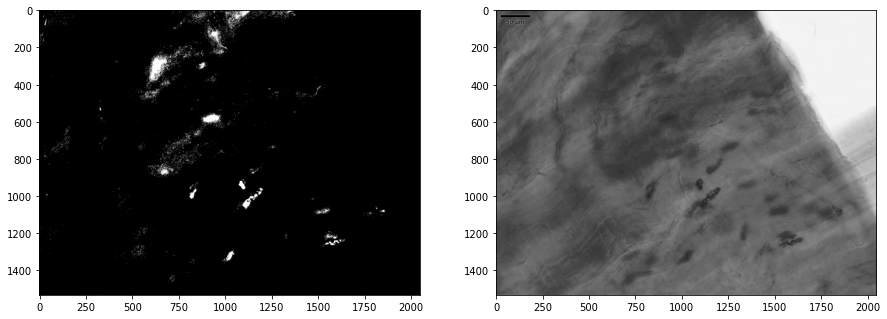

In [ ]:
path_das_imagens
df2, a, b, imagem = implementa_modelo('/content/drive/My Drive/Colab Notebooks/arrombado/cell 1.jpg')
ypredict_2 = model.predict(df2)

img_2_reshape = ypredict_2.reshape(a,b)
fig, axs = plt.subplots(ncols = 2,figsize=(15,15))
axs[0].imshow(img_2_reshape, cmap = 'gray', )
axs[1].imshow(imagem, cmap = 'gray', )

function executed


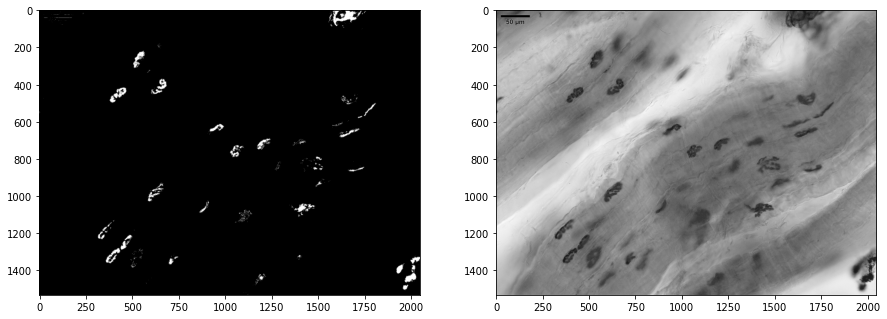

In [ ]:
df2, a, b, imagem = implementa_modelo('/content/drive/My Drive/Colab Notebooks/arrombado/cell 2.jpg')
ypredict_2 = model.predict(df2)

img_2_reshape = ypredict_2.reshape(a,b)
fig, axs = plt.subplots(ncols= 2,figsize=(15,15))
axs[0].imshow(img_2_reshape, cmap = 'gray', )
axs[1].imshow(imagem, cmap = 'gray', )

function executed


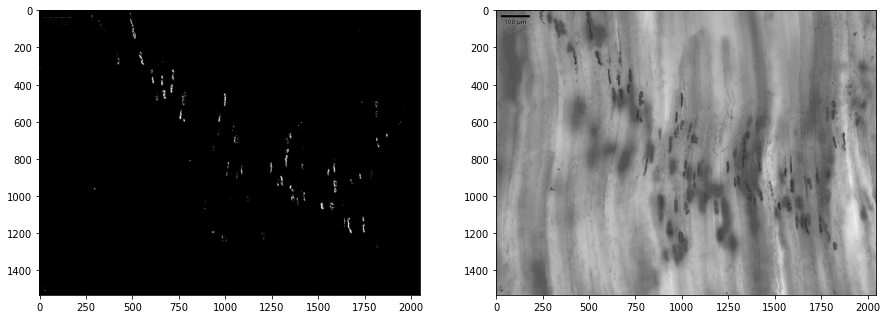

In [ ]:
df2, a, b, imagem = implementa_modelo('/content/drive/My Drive/Colab Notebooks/arrombado/cell 3.jpg')
ypredict_2 = model.predict(df2)

img_2_reshape = ypredict_2.reshape(a,b)
fig, axs = plt.subplots(ncols = 2,figsize=(15,15))
axs[0].imshow(img_2_reshape, cmap = 'gray', )
axs[1].imshow(imagem, cmap = 'gray', )

# Resultados

For a first run, the results are very proeminent. They have segmented mostly the area of interest, as the comparison pics show. On a closer look, the segmented areas are not very similar to the region of interest, so, further improoving is needed. T

here are very small white dots sprinkled in some parts of the pictures, without representing nothing of interest. Also, the oposite is quite true, with some big white areas that are not a region of interest

For the small and big white areas, a top hat and white hat transform might take care of this issue

And also, the images that were loaded to the feature extractor were not preprocessed, so they were not standardized. A preprocessing sucjh as histogram equalization might work for it

Ideas:

1. Preprocessing of images, with the goal to 'normalize' the image
2. Post processing of image to remove those small and big elements of the image
3. Improve existing features within the current feature bank



